In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [343]:
img = cv2.imread(r"images\test5.png")
img_gray = cv2.imread(r"images\test5.png",0)

In [344]:
def findHorizontalLines(img):
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel = np.ones((3,3),np.uint8)
    dilate = cv2.dilate(thresh, kernel, iterations=1)
    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (70,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(dilate, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    kernel1 = np.ones((3,3),np.uint8)
    erosion = cv2.erode(lineLocations,kernel1,iterations = 1)
    
    return erosion

In [345]:
lineLocations = findHorizontalLines(img)
lineLocations.shape

(247, 524)

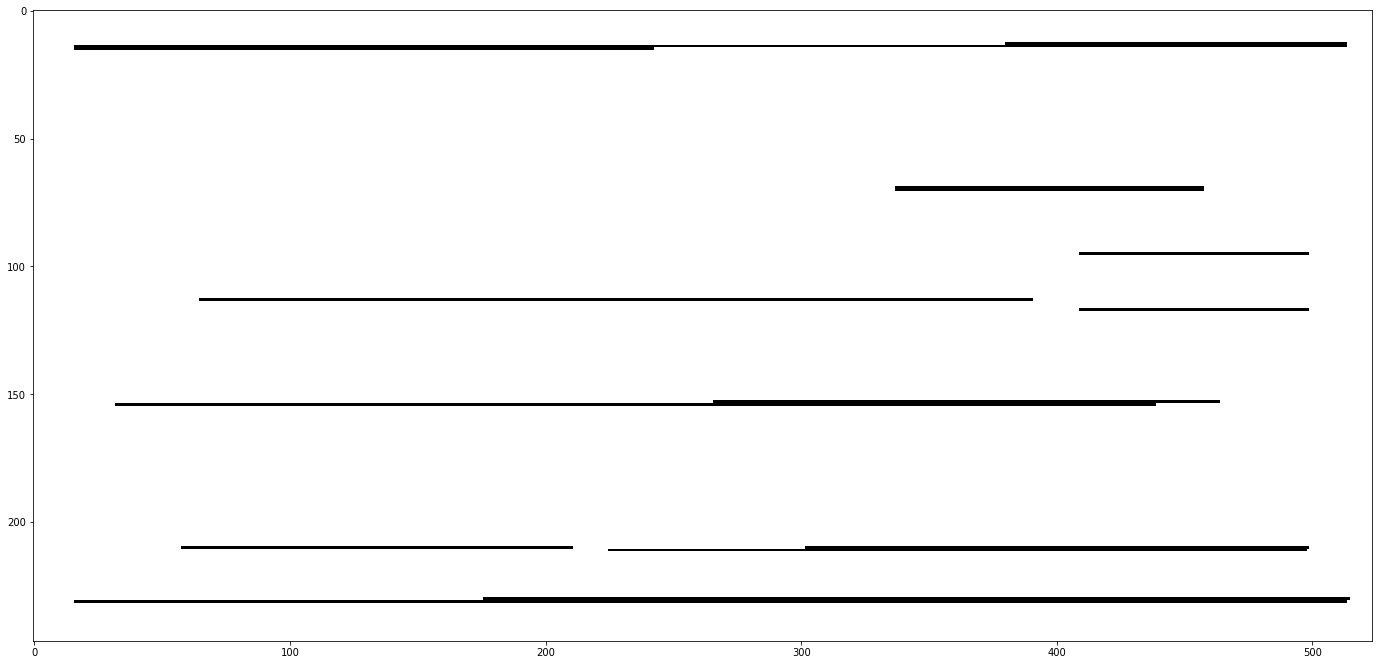

In [346]:
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

In [347]:
df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df = df_lineLocations[df_lineLocations['LineLength'] > 0]

In [348]:
lineLocations = lineLocations/255

In [349]:
def col_st(row):
    for i in range (lineLocations.shape[1]):
        if lineLocations[row,i]==1:
            return i

In [350]:
def mask(row):
    kernel = np.zeros(lineLocations.shape)
    col_start = col_st(row)
    length = int(df.loc[row][1]/255)
    col_end = col_start+length
    kernel[row-20:row+5,col_start:col_end-1]=1
    return kernel

In [351]:
def mask_n_crop(img_gray):
    list_images = []
    for i in df.index:
        col_start = col_st(i)
        length = int(df.loc[i][1]/255)
        col_end = col_start+length
        image = mask(i) * img_gray/255
        im = image[i-20:i+5,col_start:col_end-1]    
        img = (im * 255).astype(np.uint8)
        list_images.append(img)
    return list_images

In [352]:
li = mask_n_crop(img_gray)
li[9].shape

(25, 406)

In [354]:
def remove_line(gray):
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(gray, [c], -1, (255,255,255), 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    
    #make the image binary
    f = 255 * (np.round(result/255).astype(np.uint8))
    
    return f

In [413]:
cv2.imshow("img",remove_line(li[6]))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [442]:
def contour(img_gray):

    img_ = remove_line(img_gray)
    thresh1 = cv2.threshold(img_, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)[1]
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 4))
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    word_imgs = []
    
    im2 = img_.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        img = im2[y:y+h,x:x+w]
        
        scale_percent = 200 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)

        # resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
        
        word_imgs.append(resized)
        
    return word_imgs

In [448]:
words = contour(li[9])

In [454]:
cv2.imshow("img",words[4])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [460]:
def fun(line_img):
    line = ''
    if line_img.shape[0] == 0:
        return 0
    words = contour(line_img)
    key = len(words)
    di = {key:words}
    while key>0:
        line += service(words[key]) + " "
        key-=1
    return line

In [458]:
len(fun(li[6])[3])

3

In [431]:
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

In [434]:
thisdict['brand']

'Ford'